# Particles

In [3]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

No pytransport functionality
No pytransport functionality


In [1]:
# ---------------------------- SIMULATION CHECKING FUNCTIONS ----------------------------


def ls(path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix='' , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0, only_sim_obj = True):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    if only_sim_obj:
        with open(path + folder + '/input_cache/config_sim.yaml', 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
            obj_list = config['run']['save_list']

    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP', 'BLM', 'TCLA']:
                if only_sim_obj:
                    if any([file_lines[i-1] in obj for obj in obj_list]):
                        print(file_lines[i-1]+suffix+' = '+file_lines[i])
                else:    
                    print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])



def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    with open(path + folder + '/input_cache/config_sim.yaml', 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])


def check_hdf_keys(input_path):
    with pd.HDFStore(input_path, 'r') as store:
         keys = store.keys()
    for key in keys:
        print(key)



In [2]:
# ----------------------------- TURN AND COMPARISON FUNCTIONS ----------------------------


def plot_at_turn(TCCS, TARGET, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part
    df_TARGET_all = TARGET.data

    df_TCCS = df_TCCS[df_TCCS['this_turn']==n_turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==n_turn]
    df_TARGET_all = df_TARGET_all[df_TARGET_all['this_turn']==n_turn]

    print("IMPACT ON TCCS AT TURN ", n_turn)    
    fig_TCCS, ax_TCCS_list = TCCS.plot_distributions(df_TCCS['x'], df_TCCS['y'], df_TCCS['px'], df_TCCS['py'], xpcrit=True, return_fig=True, percentile = percentile)
    if plot_whole:
        ax_TCCS_list[1].hist(TCCS.data['y'], bins=100, alpha = 0.3) 
        ax_TCCS_list[2].scatter(TCCS.data['x'], TCCS.data['y'], alpha = 0.03, zorder=1) 
        ax_TCCS_list[4].hist(TCCS.data['py'], bins=100, alpha = 0.3) 

    print("IMPACT ON TARGET AT TURN ", n_turn)    
    fig_TARGET, ax_TARGET_list = TARGET.plot_distributions(df_TARGET['x'], df_TARGET['y'], df_TARGET['px'], df_TARGET['py'],  return_fig=True, percentile = percentile)
    if plot_whole:
        ax_TARGET_list[2].scatter(TARGET.data['x'], TARGET.data['y'], alpha = 0.03, zorder=1) 

    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]

    print('TCCS impacts: ', len(df_TCCS), '\ninside critical angle:', len(channable)  ,'\nTARGET impacts' ,len(df_TARGET), '\nCommon impacts: ', len(common_ids))

    df_common = df_TCCS[df_TCCS['particle_id'].isin(common_ids)]
    print("\nIMPACTS ON TARGET FROM TCCS AT TURN ", n_turn)    
    fig_common, ax_common_list = TCCS.plot_distributions(df_common['x'], df_common['y'], df_common['px'], df_common['py'], xpcrit=True, return_fig=True)

    if plot_chann:
        ax_TCCS_list[2].scatter(df_common['x'], df_common['y'], color='pink',zorder=10, alpha =0.01) 
        ax_TCCS_list[4].hist(df_common['py'], bins=90, alpha = 0.3, color='pink')


def check_plot_turns(TCCS, TARGET, turns=200):
    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part
    tccs, target, channable, common = [], [], [], []
    x = np.arange(turns)
    for t in range(turns):
        tccs.append(len(df_TCCS[df_TCCS['this_turn']==t]))
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))
        tmp_TCCS = df_TCCS[df_TCCS['this_turn']==t]
        tmp_target = df_TARGET[df_TARGET['this_turn']==t]
        common_ids = np.intersect1d(tmp_TCCS['particle_id'], tmp_target['particle_id'])
        channable.append(len(tmp_TCCS[(tmp_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (tmp_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]))
        common.append(len(tmp_TCCS[tmp_TCCS['particle_id'].isin(common_ids)]))

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(x, tccs, label='TCCS impacts')
    ax.plot(x, target, label='TARGET impacts')
    ax.plot(x, channable, label='TCCS impacts inside critical angle')
    ax.plot(x, common, label='Common impacts')
    #ax.set_yscale('log')
    ax.legend()
    print(np.argmax(target))



def plot_turn_impacts(impact_list, turns=200, threshold=10000, labels = None, linestyles = None, return_fig = False):
    if not hasattr(impact_list, '__iter__'):
            impact_list = [impact_list]
    dfs = [i.impact_part for i in impact_list]

    x = np.arange(turns)
    fig, ax = plt.subplots(figsize=(10, 7))

    for i, df in enumerate(dfs):
        imp = []
        for t in range(turns):
            imp.append(len(df[df['this_turn']==t]))

        if labels is not None:
            label=labels[i]
        else:
             label = f'impacts {i}'
        if linestyles is not None:
            linestyle=linestyles[i]
        else:
            linestyle = '-'
        ax.plot(x, imp, label=label, linewidth=2, linestyle=linestyle, marker='o')
        peaks = []
        for i in range(1, len(imp)):
            if imp[i] - imp[i-1] > threshold:
                peaks.append(i)
        print('\nPeaks at turns: ', peaks)       
        print('Absolute max: ', np.argmax(imp))

    ax.legend()
    ax.set_xlabel('Turn number')
    ax.set_ylabel('N impacts')

    if return_fig:
        return fig, ax  

def calculate_target_impacts_threshold(TARGET, threshold , turns=200):
    df_TARGET = TARGET.impact_part
    target = []
    x = np.arange(turns)
    for t in range(turns):
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))

    print('thershold: ', threshold, 'before thershold: ', np.sum(target[:threshold]), f"{  (np.sum(target[:threshold])/np.sum(target)*100):.{1}f}% \t after thershold: ", np.sum(target[threshold:]), f"   {(np.sum(target[threshold:])/np.sum(target)*100):.{1}f}%")

In [4]:
class ParticleAnalysis():

    def __init__(self, n_sigma, length, xdim, ydim, sigma, beam = 2, plane = 'V', jaw_L = None ):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        if jaw_L is not None:
            self.jaw_L = jaw_L
        else:
            self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.xdim/2
        self.ref_y = self.jaw_L - self.n_sigma*self.sigma 

        self.impact_part = None
        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.coll_names = {'TCCS': 'tccs.5r3.b2', 'TCCP': 'tccp.4l3.b2', 'TARGET': 'target.4l3.b2', 'TCLA': 'tcla.a5l3.b2'}
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/", n_return = None):

        test_list = [path + i for i in os.listdir(path) if prefix_name in i]
        for test_name in test_list:

            n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

            path_list =[]

            for i in range(n_jobs):
                file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                if os.path.exists(file_path_part):
                    path_list.append(file_path_part)

            n_jobs_verify  = len(path_list)
            if n_jobs != n_jobs_verify:
                print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        
        if n_return is not None:
            return path_list[:n_return]
        else:
            return path_list   
    


    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       n_return = None,
                       part_per_job = 100000):
                
        if Condor == True:
            self.part_per_job = part_per_job
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, n_return = n_return)
            self.n_jobs = len(h5_file_path)
        else:
            h5_file_path = (subprocess.check_output("echo " + default_path + path +file_name, shell=True)).decode('ascii').strip()

        if not hasattr(h5_file_path, '__iter__') or isinstance(h5_file_path, str):
            h5_file_path = [h5_file_path]

        df_particles = pd.DataFrame()
        npart = 0
        for file in h5_file_path:

            job_id = int(file.split('Job.')[1].split('/')[0]) if Condor else 0
            
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*job_id    
                df_tmp['parent_particle_id'] = df_tmp['parent_particle_id'] + part_per_job*job_id
                df_particles = pd.concat([df_particles, df_tmp])
            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)
                       
        self.npart = npart       
        self.data = df_particles
            
        p0c = None
        if len(self.data['p0c'].unique()) == 1:
            p0c = self.data['p0c'].unique()[0]
        else:
            print('There are particles at different energies')            
        self.p0c = p0c

        hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        self.impact_part = self.data[hit_mask]
    
    def get_job_id(self, abs_id, TCCS = None):
        
        if not hasattr(abs_id, '__iter__') or isinstance(abs_id, str):
            abs_id = [abs_id]
        elif isinstance(abs_id, pd.Series):
            abs_id = abs_id.to_list()

        for id in abs_id:
            print(f'\nabs_id: {id}')
            if TCCS is not None:
                df_tccs = TCCS.data
                df_tccs = df_tccs[df_tccs['particle_id'] == id]
                if len(df_tccs==1):
                    print('Part is in TCCS')
                    if df_tccs.py.iloc[0] > TCCS.align_angle - np.abs(TCCS.xp_crit) and df_tccs.py.iloc[0] < TCCS.align_angle + np.abs(TCCS.xp_crit):
                        print('Part in critical angle')
                    else:   
                        print('Part is NOT in critical angle')
                else:
                    print('Particle is NOT in TCCS')
               
                
            number = id/self.part_per_job
            integer_part = int(divmod(number, 1)[0])

            fractional_part = int(np.round((number % 1) * self.part_per_job))

            print('Turn of channeling: ', self.data[self.data['particle_id'] == id].this_turn.iloc[0])
            print(f"Job Number: {integer_part}, ID: {fractional_part} ")

    def hist_jobs(self):   
        jobs = divmod(self.data['particle_id']/self.part_per_job, 1)[0]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(jobs, bins=self.n_jobs)
        ax.set_xlabel('job_id')
        ax.set_ylabel('n_part')    

    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, linewidth=1, edgecolor='r', facecolor='none', zorder=100)
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y, axins_params = ["100%", "5%", "right", -6], **kwargs):

        h = ax.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm(), zorder=2)#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_yticks()])
        ax_tw = ax.twinx()
        sigma_abs = self.sigma #self.jaw_L/self.n_sigma
        ax_tw.set_ylim((ax.get_ylim()[0]-self.ref_y)/sigma_abs, (ax.get_ylim()[1]-self.ref_y)/sigma_abs)
        
        if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
        ax_tw.set_yticks(yticks)
        ax_tw.set_ylabel(r' n $\sigma$')
        
        ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
        axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')


            


    #HOME
    def plot_py_distribution(self, fig, ax, py, fit = None, **kwargs):

        '''if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            py = py[(py >= py_min) & (py <= py_max)]'''

        ax.hist(py, bins=100) 
        ax.set_xlabel(r'py [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax.get_xticks()])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']
        
        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            pym = (py >= py_min) & (py <= py_max)
        
            px_min = np.percentile(px,kwargs['percentile'])
            px_max = np.percentile(px,100-kwargs['percentile'])
            pxm = (px >= px_min) & (px <= px_max)

            y_min = np.percentile(y,kwargs['percentile'])
            y_max = np.percentile(y,100-kwargs['percentile'])
            ym = (y >= y_min) & (y <= y_max)
         
            x_min = np.percentile(x,kwargs['percentile'])
            x_max = np.percentile(x,100-kwargs['percentile'])
            xm = (x >= x_min) & (x <= x_max)

        else:
            pym = np.ones(len(py), dtype=bool)
            pxm = np.ones(len(px), dtype=bool)
            ym = np.ones(len(y), dtype=bool)
            xm = np.ones(len(x), dtype=bool)
            
        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x[xm & ym], bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        if lines:
            ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
            ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=ax1.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax1.get_xticks()])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y[xm & ym], bins=100) 
        ax2.set_xlabel('y [mm]')
        if lines:
            ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
            ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=ax2.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax2.get_xticks()])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)
        self.plot_xy_distribution(fig1, ax3, x, y)
        if lines:
            self.plot_rectangle(ax3, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px[pxm & pym], bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")        
        ax12.set_xticks(ticks=ax12.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax12.get_xticks()])


        ax22 = fig1.add_subplot(2,3,5)
        self.plot_py_distribution(fig1, ax22, py[pym & pxm], **kwargs)


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm(), zorder=2)  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=ax32.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_xticks()])
        ax32.set_yticks(ticks=ax32.get_yticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_yticks()])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        if return_fig:
            return fig1, [ax1, ax2, ax3, ax12, ax22, ax32]  
        else:
            plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss



    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, return_fig = False, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit

        if return_fig:
            return self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], return_fig = True ,  sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, **kwargs)
        else:
            self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, **kwargs)

    def plot_phasespace(self, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(self.data['x'], self.data['px'], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(self.data['y'], self.data['py'], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')
        ax2.axvline(self.jaw_L + 10e-6, color = 'r', linestyle = '-')
        ax2.axhline(self.align_angle, color = 'r', linestyle = '-')
        ax2.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
        ax2.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')
        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, zoom = zoom, layout = layout,  outfile = outfile)

    def plot_lossmap(self, zoom = None, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", outfile = None):

        if zoom == 'IR7':
            lm.plot_lossmap(self.lossmap, zoom = True, layout = layout,  outfile = outfile)
        elif zoom == 'IR3':
            lm.plot_lossmap(self.lossmap, zoom_range = [6000,7200], layout = layout,  outfile = outfile)
        else:
            lm.plot_lossmap(self.lossmap, zoom = False, layout = layout,  outfile = outfile)
            
    def compute_losses(self, path=None):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        colls_length_dict = {self.coll_names['TCLA']: 1.0, self.coll_names['TCCS']: 0.004, self.coll_names['TCCP']: 0.07, self.coll_names['TARGET']: 0.005,  'tcp.d6r7.b2': 0.6}
        losses_df = df[df['name'].isin(colls_length_dict.keys())].copy()
        losses_df.loc[:, 'length'] = losses_df['name'].map(colls_length_dict)
        losses_df.loc[:, 'npart']  = losses_df['losses'] * losses_df['length']
        return losses_df

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')







# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, jaw_L = None,  bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2, #eV/m Silicon    #dp_Si = 1.92e-10 #m
                xp_version = 'code'
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma, jaw_L = jaw_L)

    
    self.align_angle = align_angle
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 
    self.xp_version = xp_version


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)

    
    if self.xp_version == 'book': 
        xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
        Rcrit = self.p0c/self.en_crit
        self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)

    elif self.xp_version == 'manual':
        dp = 1.92e-10 
        aTF = 0.194e-10
        uT = 0.075e-10
        xc = dp/2 -0.6565*uT
        eta = (xc*2/dp)**2
        Rcrit = self.p0c/(2*eta*self.pot_crit) * xc
        self.xp_crit = np.sqrt(2*eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)

    elif self.xp_version == 'code':
        dp = 1.92e-10 
        Rcrit = self.p0c/(2*self.pot_crit) * (dp/2)
        self.xp_crit = np.sqrt(2*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)
    
    
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")
    

  def plot_py_distribution(self, fig, ax, py, print=True, **kwargs):
        
        super().plot_py_distribution(fig, ax, py, **kwargs)


        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print:
                        ax.set_title(f'N particle inside critical angle range: {chann}')






  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', len(self.impact_part), f'\t{chann_num/len(self.impact_part)*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self, plot = True, return_fig = False):

    data = self.data[['py', 'at_element']]
    min_py = data['py'].min()
    max_py = 0 # data['py'].max()
    
    n_steps = 1000
    x = np.linspace(min_py + self.xp_crit, max_py - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data['py'] > x[i] - self.xp_crit) & (data['py'] < x[i] + self.xp_crit)
        y.append(len(data['py'][mask]))

    best_angle = x[y.index(max(y))]

    if plot:
        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'g', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        self.plot_py_distribution(fig1, ax2, data['py'], xpcrit=True, align_angle = best_angle, print=False)

        chann_mask = (data['py'] > self.align_angle  - np.abs(self.xp_crit)) & (data['py'] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data['py'][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        if return_fig:
            return fig1, [ax1, ax2] 

    print(f'Delta angle {best_angle - self.align_angle}')



  def align_TCCS(self):

        best_jawL = min( self.data['y'])

        new_sigma = best_jawL/self.jaw_L*self.n_sigma
        self.abs_y_low = best_jawL
        self.abs_y_up = best_jawL + self.ydim
        self.n_sigma = new_sigma
        self.jaw_L = best_jawL
        hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        self.impact_part = self.data[hit_mask]




# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, beam = 2, plane = 'V', jaw_L = None):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane, jaw_L = jaw_L)
    
    


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return=n_return)

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids!') #: {data[duplicated_mask]}')

    


  def optimize_POT(self, set = False, mode='fit', plot = True):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        if plot:
            fig1 = plt.figure(figsize=(16, 5))
            ax1 = fig1.add_subplot(1,2,1)
            ax1.plot(steps, n_part)
            ax1.set_xlabel('y position [mm]')
            ax1.set_ylabel("n_part")
            ax1.axvline(best_jawL, color = 'g', linestyle = '-')
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

            ax3 = fig1.add_subplot(1,2,2)
            super().plot_xy_distribution(fig1, ax3, x, y)
            super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

            hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

            fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')




      

In [5]:
def plot_at_turn_simple(OBJ, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df = OBJ.data

    df = df[df['this_turn']==n_turn]


    print("IMPACT ON TCCS AT TURN ", n_turn)    
    fig, ax_list = OBJ.plot_distributions(df['x'], df['y'], df['px'], df['py'], lines=False, return_fig=True, percentile = percentile)
    if plot_whole:
        ax_list[1].hist(OBJ.data['y'], bins=100, alpha = 0.3) 
        ax_list[2].scatter(OBJ.data['x'], OBJ.data['y'], alpha = 0.03, zorder=1) 
        ax_list[4].hist(OBJ.data['py'], bins=100, alpha = 0.3) 

   

# Analysis

In [27]:
ls()

test_best_beam__target_absorber_20240510-0926
test_best_beam__target_absorber_20240508-1822
test_1tev_circ_smaller___20240508-1631
test_1tev_pencil_retracted___20240508-1540
test_1tev_tccs_retracted__20240508-1420
test_1tev_gen_ip1___20240508-1416
RUN3_ANG_SCAN_opt_new__target_absorber_20240506-1431
GR_TEST_losses_B2H___20240503-1754
GR_TEST_B2H___20240503-1422
GR_TEST_B2V___20240503-1421
GR_TEST___20240503-1356
RUN3_ANG_SCAN_-1.7__target_absorber_20240502-1057
RUN3_ANG_SCAN_3.8__target_absorber_20240502-1053
RUN3_ANG_SCAN_2.3__target_absorber_20240502-1053
RUN3_ANG_SCAN_0.8__target_absorber_20240502-1052
RUN3_ANG_SCAN_-0.6__target_absorber_20240502-1052
RUN3_ANG_SCAN_-2.1__target_absorber_20240502-1051
RUN3_ANG_SCAN_-3.6__target_absorber_20240502-1051
RUN3_ANG_SCAN_-5.1__target_absorber_20240502-1050
RUN3_ANG_SCAN_-6.6__target_absorber_20240502-1049
RUN3_ANG_SCAN_-8.1__target_absorber_20240502-1048
RUN3_ANG_SCAN_-8.1__target_absorber_20240502-1047
RUN3_PH_SCAN_155__target_absorber_202

In [10]:
t_s = 'test_1tev_circ_smaller___20240508-1631'
t_p = 'test_1tev_gen_ip1___20240508-1416'

In [16]:
get_analysis_init(t_p, '_tp', n = 50)

TCCP_tp = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502317698e-05, sigma=0.0009633910371328057, jaw_L=0.004816507499296524)
PIXEL_tp = TargetAnalysis(n_sigma=12.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.0009745202758080853)


In [17]:
TCCP_tp = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502317698e-05, sigma=0.0009633910371328057, jaw_L=0.004816507499296524)
PIXEL_tp = TargetAnalysis(n_sigma=12.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.0009745202758080853)

In [18]:
TCCP_tp.load_particles(t_p, 'TCCP_impacts')

In [19]:
PIXEL_tp.load_particles(t_p, 'PIXEL_impacts')

There are repeated particle ids!


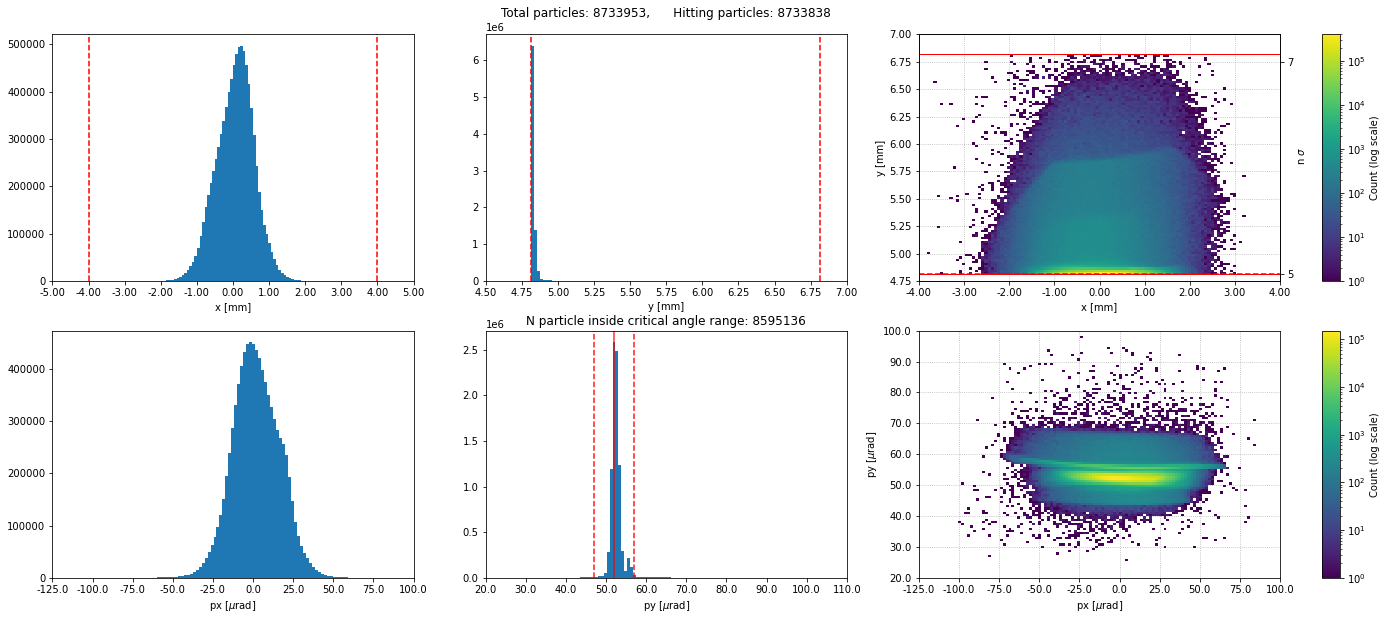

In [20]:
TCCP_tp.compute_impact_particles(xpcrit = True)

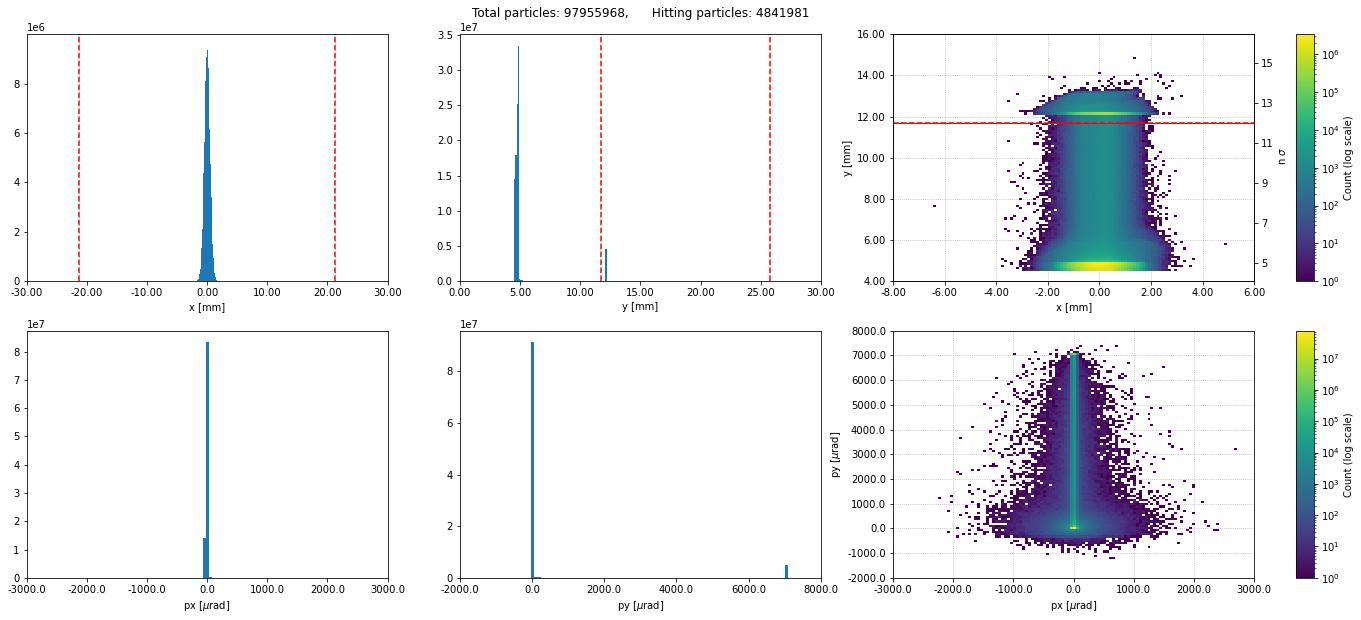

In [21]:
PIXEL_tp.compute_impact_particles()

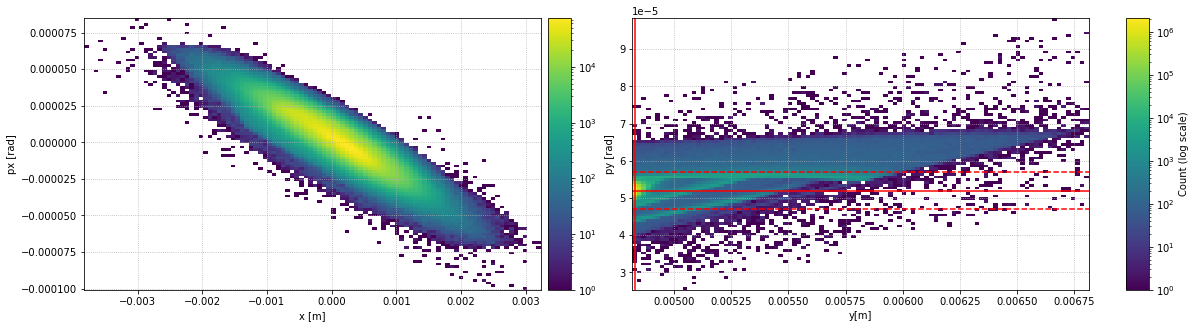

In [22]:
TCCP_tp.plot_phasespace()

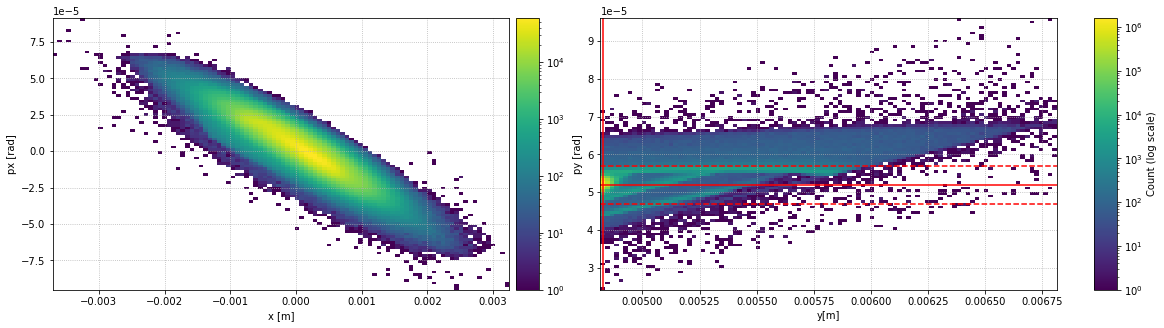

In [16]:
TCCP_ts.plot_phasespace()

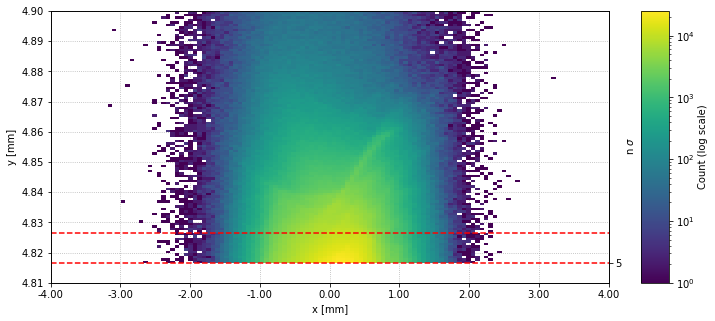

In [20]:
data = TCCP_ts.data
data = data[(data['y']>TCCP_ts.jaw_L) & (data['y']<0.0049)]
fig, ax = plt.subplots(figsize=(10, 5))
TCCP_ts.plot_xy_distribution(fig, ax, data['x'], data['y'])
ax.axhline(TCCP_ts.jaw_L+10e-6, color = 'r', linestyle = '--')

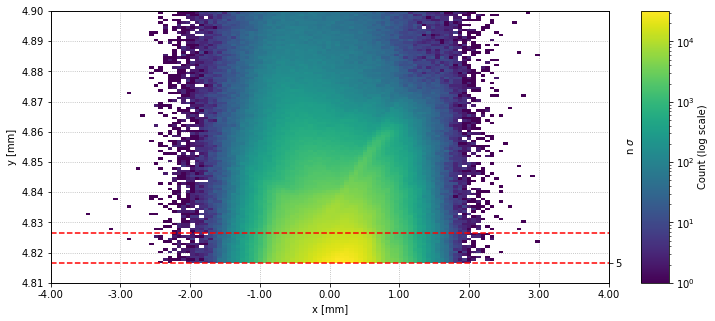

In [26]:
data = TCCP_tp.data
data = data[(data['y']>TCCP_tp.jaw_L) & (data['y']<0.0049)]
fig, ax = plt.subplots(figsize=(10, 5))
TCCP_tp.plot_xy_distribution(fig, ax, data['x'], data['y'])
ax.axhline(TCCP_tp.jaw_L+10e-6, color = 'r', linestyle = '--')

In [29]:
get_analysis_init(t_s, '_ts', n = 50)

TCCP_ts = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502317698e-05, sigma=0.0009633910371328057, jaw_L=0.004816507499296524)
PIXEL_ts = TargetAnalysis(n_sigma=12.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.0009745202758080853)


In [6]:
TCCP_ts = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502317698e-05, sigma=0.0009633910371328057, jaw_L=0.004816507499296524)
PIXEL_ts = TargetAnalysis(n_sigma=12.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.0009745202758080853)

In [11]:
TCCP_ts.load_particles(t_s, 'TCCP_impacts', n_return = 80)

In [12]:
PIXEL_ts.load_particles(t_s, 'PIXEL_impacts', n_return = 80)

There are repeated particle ids!


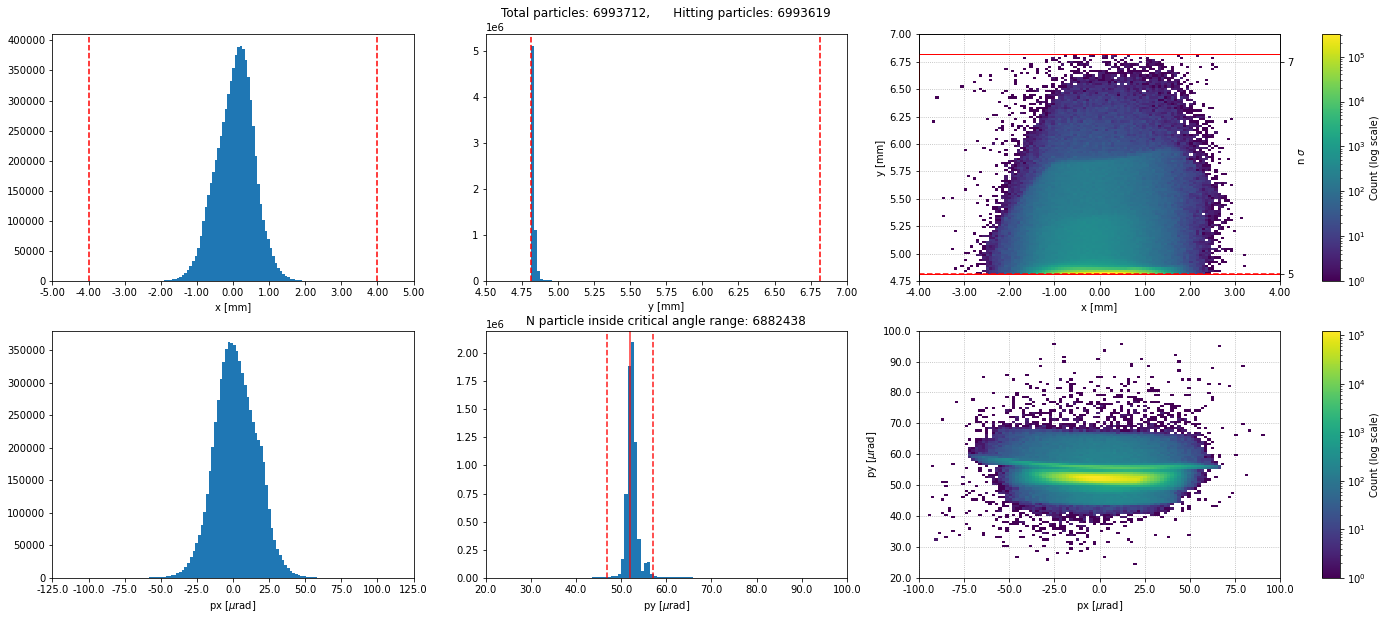

In [13]:
TCCP_ts.compute_impact_particles(xpcrit = True)

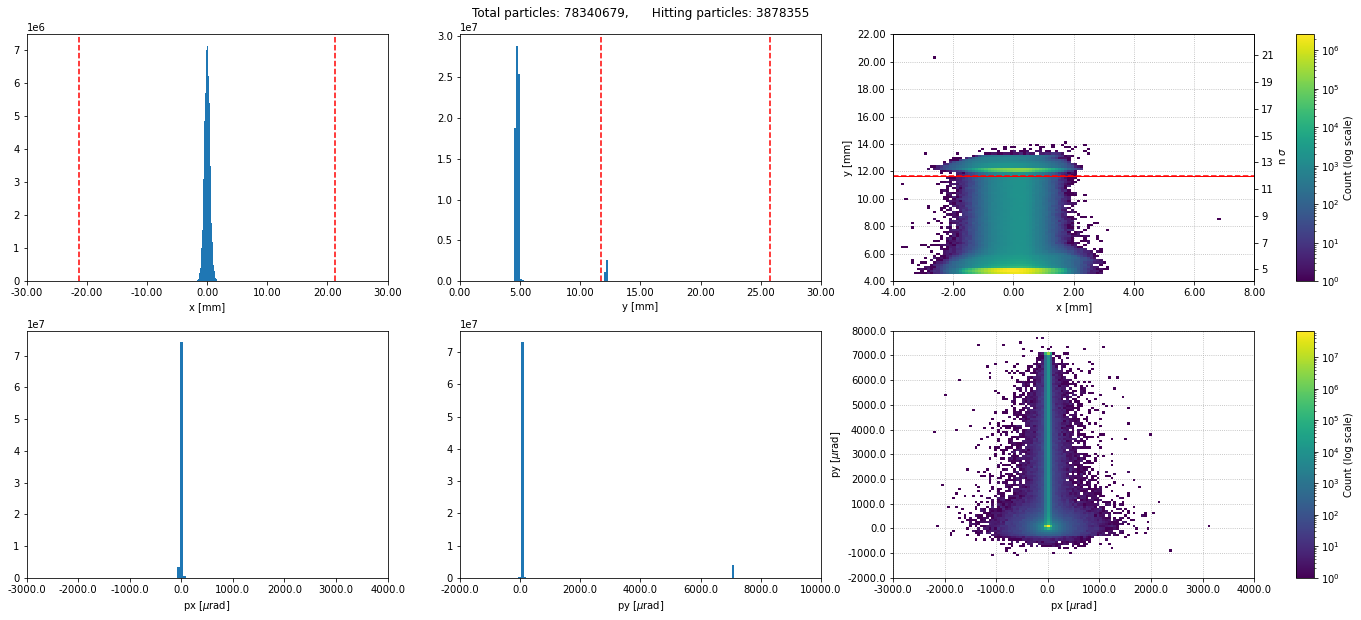

In [14]:
PIXEL_ts.compute_impact_particles()


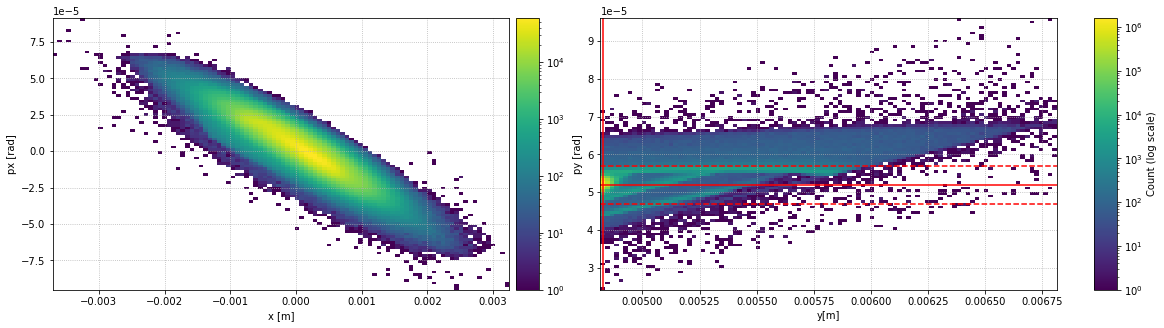

In [ ]:
TCCP_tp.plot_phasespace()

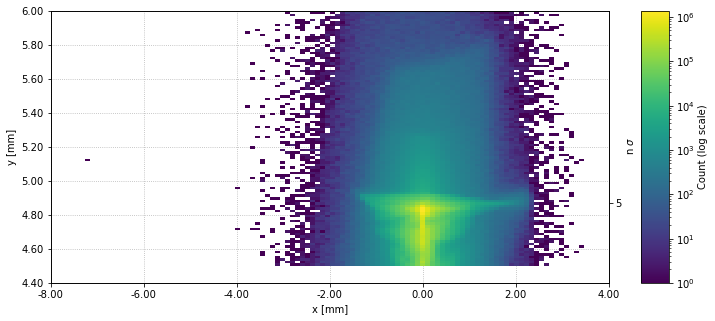

In [15]:
data = PIXEL_ts.data
data = data[(data['y']>0.004) & (data['y']<0.006)]
fig, ax = plt.subplots(figsize=(10, 5))
PIXEL_ts.plot_xy_distribution(fig, ax, data['x'], data['y'])


# TWISS

In [21]:
TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'
TCP_name = 'tcp.d6r7.b2'

def load_line(line_path, coll_path):

    context = xo.ContextCpu(omp_num_threads='auto')


    line = xt.Line.from_json(line_path)
    coll_file = coll_path

    end_s = line.get_length()

    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    dx = 1e-11
    TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2+ dx)
    TCLA_loc = line.get_s_position(TCLA_name)

    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name = TCCS_name)
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCS_name + '_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCP_name + '_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TARGET_name + '_aper')

    coll_manager = xc.CollimatorManager.from_yaml(coll_file, line=line, beam=2, _context=context, ignore_crystals=False)
    coll_manager.install_everest_collimators(verbose=False)

    twiss = line.twiss(method = '4d')

    

    return twiss, line

In [27]:
line_file  = './input_files/2024_Run3/ramp.9_b2.json'
coll_file = "./input_files/colldbs/ramp.9.yaml"

line_file  = './input_files/Run3_phase_scan/flat_top_b2_phadv_150_new.json'
coll_file = "./input_files/colldbs/flat_top.yaml"

tw, line = load_line(line_file, coll_file)

Loading line from dict:   0%|          | 0/175742 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_xcoll`.
Found suitable prebuilt kernel `default_xcoll_frozen_energy`.


In [28]:
normalized_emittance = 3.5e-6
beta_rel = float(line.particle_ref.beta0)
gamma = float(line.particle_ref.gamma0)
emittance_phy = normalized_emittance/(beta_rel*gamma)
sigma_TCCS = np.sqrt(emittance_phy*tw['bety',TCCS_name])
sigma_TCCP = np.sqrt(emittance_phy*tw['bety',TCCP_name])
sigma_ip1 = np.sqrt(emittance_phy*tw['bety', 'ip1'])
sigma_TCP = np.sqrt(emittance_phy*tw['bety', TCP_name])

In [29]:
1e-6 / sigma_TCP

0.0053974776172385245

In [31]:
tw['y', 'ip1']

3.450370645600911e-07

In [19]:
df.query('name == "tccp.4l3.b2"')

NameError: name 'df' is not defined

In [32]:
ls()

test_best_beam__target_absorber_20240510-0926
test_best_beam__target_absorber_20240508-1822
test_1tev_circ_smaller___20240508-1631
test_1tev_pencil_retracted___20240508-1540
test_1tev_tccs_retracted__20240508-1420
test_1tev_gen_ip1___20240508-1416
RUN3_ANG_SCAN_opt_new__target_absorber_20240506-1431
GR_TEST_losses_B2H___20240503-1754
GR_TEST_B2H___20240503-1422
GR_TEST_B2V___20240503-1421
GR_TEST___20240503-1356
RUN3_ANG_SCAN_-1.7__target_absorber_20240502-1057
RUN3_ANG_SCAN_3.8__target_absorber_20240502-1053
RUN3_ANG_SCAN_2.3__target_absorber_20240502-1053
RUN3_ANG_SCAN_0.8__target_absorber_20240502-1052
RUN3_ANG_SCAN_-0.6__target_absorber_20240502-1052
RUN3_ANG_SCAN_-2.1__target_absorber_20240502-1051
RUN3_ANG_SCAN_-3.6__target_absorber_20240502-1051
RUN3_ANG_SCAN_-5.1__target_absorber_20240502-1050
RUN3_ANG_SCAN_-6.6__target_absorber_20240502-1049
RUN3_ANG_SCAN_-8.1__target_absorber_20240502-1048
RUN3_ANG_SCAN_-8.1__target_absorber_20240502-1047
RUN3_PH_SCAN_155__target_absorber_202

In [12]:
det = 'TEST_RUN3_1TeV_circ_halo_and_Gauss___20240423-1801'

In [15]:
check_config(det)


{'engine': 'everest', 'seed': 1, 'beam': '2', 'plane': 'V', 'turns': 200, 'nparticles': 100000, 'normalized_emittance': 3.5e-06, 'turn_on_cavities': False, 'TCCS_align_angle_step': 0, 'TCCS_gap': 99.9, 'TARGET_gap': 99.9, 'TCCP_gap': 5.0, 'PIXEL_gap': 12.0, 'save_list': ['losses', 'TCCP_impacts', 'PIXEL_impacts'], 'target_mode': '', 'input_mode': 'circular_halo', 'load_input_path': '/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7____20240319-1209'}


In [18]:
get_analysis_init(det, '_det')

TCCP_det = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502317698e-05, sigma=0.0009633910371328057, jaw_L=0.004816507499296524)
PIXEL_det = TargetAnalysis(n_sigma=12.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.0009745202758080853)


In [19]:
TCCP_det = CrystalAnalysis(n_sigma=5.0, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=5.197408502317698e-05, sigma=0.0009633910371328057, jaw_L=0.004816507499296524)
PIXEL_det = TargetAnalysis(n_sigma=12.0, length=0, ydim=0.01408, xdim=0.04246,sigma=0.0009745202758080853)

In [20]:
TCCP_det.load_particles(det, 'TCCP_impacts')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_RUN3_1TeV_circ_halo_and_Gauss___20240423-1801


KeyboardInterrupt: 

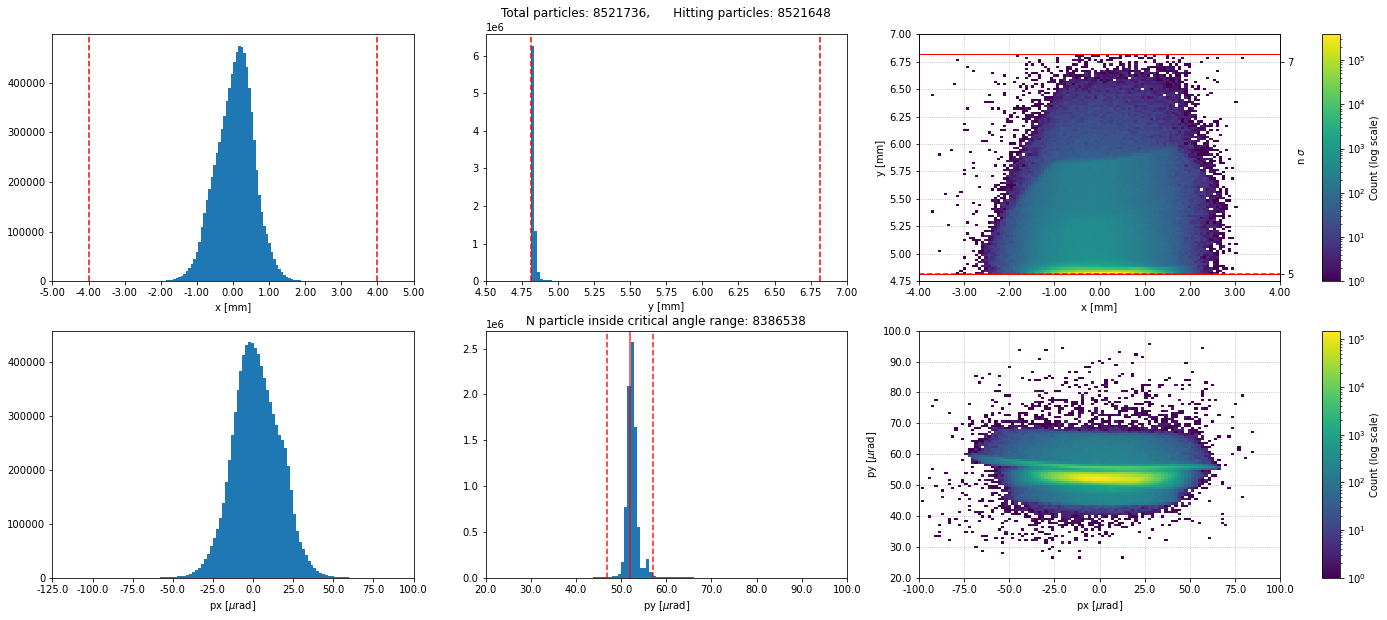

In [ ]:
TCCP_det.compute_impact_particles( xpcrit=True)

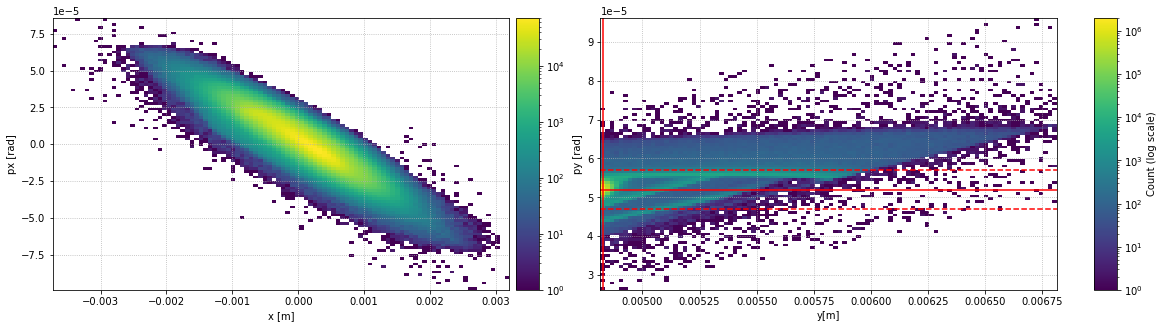

In [ ]:
TCCP_det.plot_phasespace()

In [ ]:
TCCP_det.jaw_L +10e-6

0.004826507499296523

In [ ]:
TCCP_det.sigma*0.003

2.890173111398417e-06

In [ ]:
ft = 'TEST_RUN3_TCLA_CRY5.0_flat_top___20240409-1547'

In [ ]:
get_analysis_init(ft, '_ft')

TCCS_ft = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.1764531649145031e-05, sigma=0.00033827189357608494)
TCLA_ft = TargetAnalysis(n_sigma=20.0, length=1, ydim=0.025, xdim=0.025, sigma=0.00029257754172899817)


In [ ]:
TCCS_ft = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.1764531649145031e-05, sigma=0.00033827189357608494)
TCLA_ft = TargetAnalysis(n_sigma=20.0, length=1, ydim=0.025, xdim=0.025, sigma=0.00029257754172899817)

In [ ]:
ls(_)

TypeError: can only concatenate str (not "float") to str

# Kick test

In [6]:
ls()

test_best_beam__target_absorber_20240508-1822
test_1tev_circ_smaller___20240508-1631
test_1tev_pencil_retracted___20240508-1540
test_1tev_tccs_retracted__20240508-1420
test_1tev_gen_ip1___20240508-1416
RUN3_ANG_SCAN_opt_new__target_absorber_20240506-1431
GR_TEST_losses_B2H___20240503-1754
GR_TEST_B2H___20240503-1422
GR_TEST_B2V___20240503-1421
GR_TEST___20240503-1356
RUN3_ANG_SCAN_-1.7__target_absorber_20240502-1057
RUN3_ANG_SCAN_3.8__target_absorber_20240502-1053
RUN3_ANG_SCAN_2.3__target_absorber_20240502-1053
RUN3_ANG_SCAN_0.8__target_absorber_20240502-1052
RUN3_ANG_SCAN_-0.6__target_absorber_20240502-1052
RUN3_ANG_SCAN_-2.1__target_absorber_20240502-1051
RUN3_ANG_SCAN_-3.6__target_absorber_20240502-1051
RUN3_ANG_SCAN_-5.1__target_absorber_20240502-1050
RUN3_ANG_SCAN_-6.6__target_absorber_20240502-1049
RUN3_ANG_SCAN_-8.1__target_absorber_20240502-1048
RUN3_ANG_SCAN_-8.1__target_absorber_20240502-1047
RUN3_PH_SCAN_155__target_absorber_20240430-1715
RUN3_PH_SCAN_145__target_absorber_2

In [6]:
opt = 'test_best_beam__target_absorber_20240510-0926'

In [7]:
check_config(opt, cat = ['run'])

{'engine': 'everest', 'seed': 1, 'beam': '2', 'plane': 'V', 'turns': 200, 'nparticles': 100000, 'normalized_emittance': 3.5e-06, 'turn_on_cavities': False, 'TCCS_align_angle_step': 0, 'TCCS_gap': 5.5, 'TARGET_gap': 27.0, 'TCCP_gap': 99.9, 'PIXEL_gap': 99.9, 'TCP_gap': 5.0, 'save_list': ['losses', 'TCCS_impacts', 'TARGET_impacts'], 'target_mode': 'target_absorber', 'input_mode': 'generate', 'load_input_path': '/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/INPUT_PARTICLES_HL_TCP_at_6.7____20240319-1209'}


In [8]:
TCCS_opt = CrystalAnalysis(n_sigma=5.5, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-1.5070187466734676e-05, sigma=0.00033826686603977894, jaw_L=0.0018683823892729485)
TARGET_opt = TargetAnalysis(n_sigma=27.0, length=0.005, ydim=0.002, xdim=0.008,sigma=0.00036947066934204837, jaw_L=0.00998794503358688)

In [9]:
TCCS_opt.load_particles(opt, df_key = 'TCCS_impacts')
TARGET_opt.load_particles(opt, df_key = 'TARGET_impacts')

There are repeated particle ids!


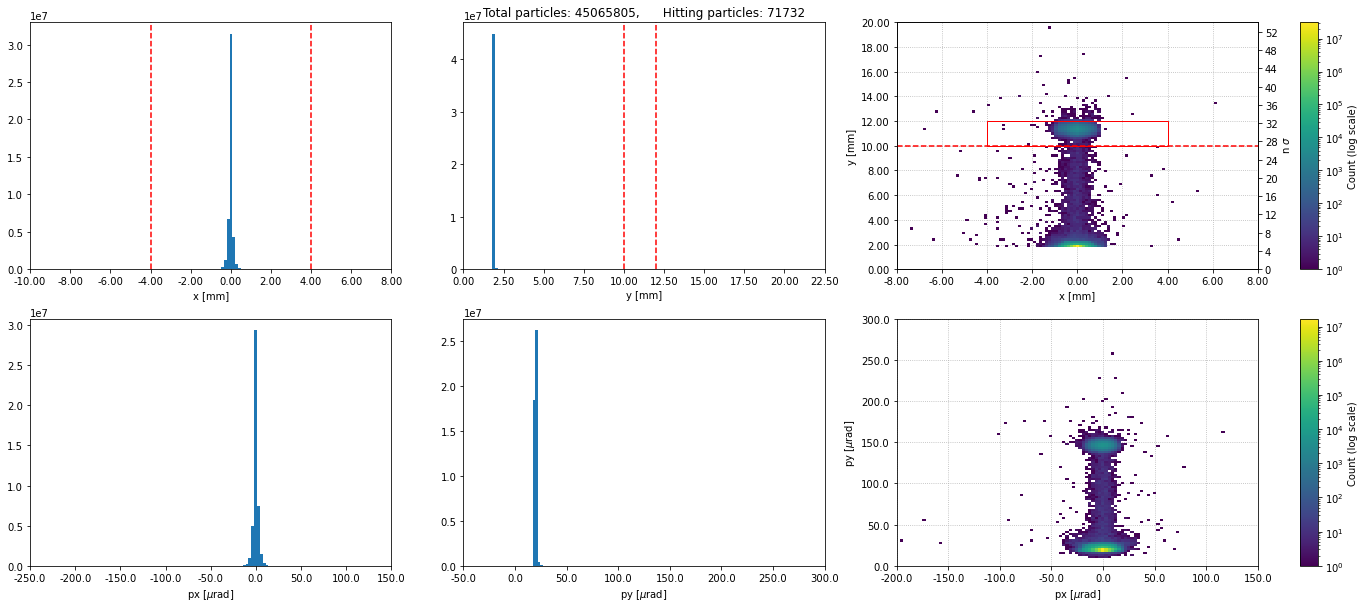

In [11]:
TARGET_opt.compute_impact_particles()

In [14]:
TARGET_opt.jaw_L - TARGET_opt.sigma*5

0.008140591686876638

In [ ]:
TARGET_opt.fit['y', 'mu']

,mu,sigma,A
x,-2.731872e-05,0.000262,10244.302951
y,1.102951e-02,0.000258,3346.499121
px,-1.237873e-07,0.000006,6302.673111
py,1.417531e-04,0.000003,3486.552443


In [36]:
linefile_ft = './input_files/Run3_phase_scan/flat_top_b2_phadv_150_new.json'
coll_ft =  './input_files/colldbs/flat_top.yaml'

In [37]:
tw_ft, line_ft = load_line(linefile_ft, coll_ft)

Loading line from dict:   0%|          | 0/175742 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_xcoll`.
Found suitable prebuilt kernel `default_xcoll_frozen_energy`.


In [43]:
def calculate_delta_phase_adv(tw):
    return (float(tw[tw.name == TCCS_name]['muy'])% 1* 2*np.pi - float(tw[tw.name == TCP_name]['muy'])% 1* 2*np.pi)

In [45]:
dphi = calculate_delta_phase_adv(tw_ft.to_pandas())

In [47]:
beta_cry = tw['bety',TCCS_name]
beta_coll = tw['bety',TCP_name]

236.328320380181

In [48]:
n_sig = TCCS_opt.n_sigma

70.94041308691665

5.5